# Синтетические данные: шумные и спокойные регионы

Спокойные регионы строятся 3 способами:
1. Извлечение реальных данных из GIAB на основании числа покрытых баз и пересечения с all_diff  
2. Модифицированное броуновское движение с разным средним  
3. Код Сергея  

Для каждого типа спокойных регионов вносятся искусственные аберрации: делеции, дупликации, фрагменты реальных сильно шумных регионов (по пересечению с all_diff)

### 1. Извлечение реальных данных из GIAB

Образец `HG001`

– **Хорошим** сигналом считаем такие регионы, которые пересекаются с all_diff менее чем на 5%, где нет ни одного варианта низкого доверия, где все базы покрыты, где Std < 0.1.  
– **Плохим** сигналом считаем сигнал в регионах, полностью лежащих в all_diff, Std > 3, где покрыто 95% баз.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, os, sys, requests, glob

In [3]:
# [Make]
# Load from lasbed, -> save to json

def load_sample(name):
    dt = pd.read_csv(f'{os.getcwd()}/../../data/GIAB/_las_noappr/{name}_p14.lasbed', sep=' ')
    dt['Sample'] = name
    return dt

def extract(real, filename):
    bp = real.filter(items=['#chr', 'start', 'end']).values.tolist()
    sig = requests.post(f'http://127.0.0.1:9950/depth/HG001', json=bp).json()
    with open(filename, 'w') as f:
        json.dump(sig, f)

LB = pd.concat([load_sample(f'HG00{i}') for i in [1]])
LB = LB[LB['covered_bases'] > 0].sample(frac=1)

real_good = LB.loc[(LB['all_diff'] < 0.05) & (LB['lc_vcf'] == 0) & (LB['covered_bases'] == 1) & (LB['Std'] < 0.1)]
real_noise = LB.loc[(LB['all_diff'] == 1) & (LB['covered_bases'] > 0.95) & (LB['Std'] > 3)][0:20]

extract(real_good,  '../../data/generated/real_good.json')
extract(real_noise, '../../data/generated/real_noise.json')

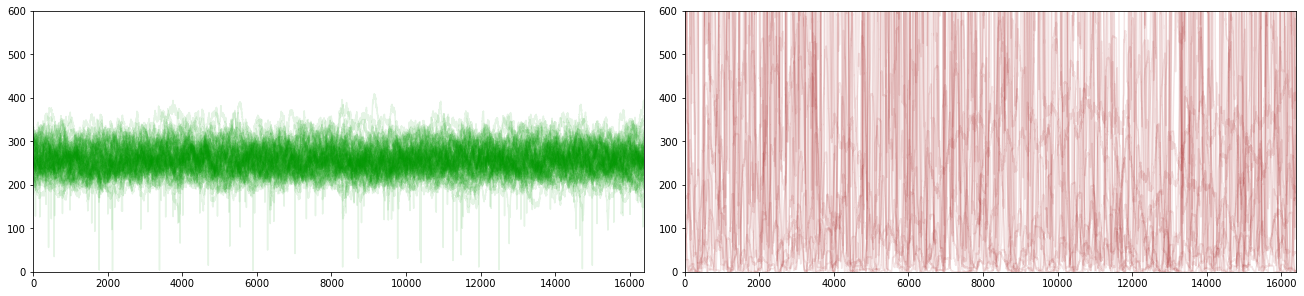

In [4]:
# [Load]
with open('../../data/generated/real_good.json', 'r') as f:
    real_good_sig = json.load(f)
with open('../../data/generated/real_noise.json', 'r') as f:
    real_noise_sig = json.load(f)

axs = plt.figure(figsize=(18, 4), constrained_layout=True).subplots(1, 2)
[axs[0].plot(one, alpha=0.1, color='#090') for one in real_good_sig]
[axs[1].plot(one, alpha=0.1, color='#900') for one in real_noise_sig]
for ax in axs:
    ax.set_xlim(0, 2**14)
    ax.set_ylim(0, 600)
plt.show()

### 2. Модифицированное броуновское движение

Простое броуновское движение генерирует сигнал, который может уходить за пределы среднего покрытия, в то время как реальный сигнал хорошего покрытия держится в районе своего среднего значения. Будем генерировать броуновское движение до тех пор, пока оно не окажется в определённом нами интервале:

In [6]:
from scipy.stats import norm

def brownian(begin, n):
    x = np.asarray(begin)
    r = norm.rvs(size = x.shape + (n,), scale=1.5)
    out = np.empty(r.shape)
    np.cumsum(r, axis=-1, out=out)
    return list(map(int, out + np.expand_dims(x, axis=-1)))

def brownian_stack(begin, offset, N, by=20000):
    out = [begin]
    while len(out) < N + 300:
        tmp = brownian(out[-1], by)
        if min(tmp) < begin - offset: continue
        if max(tmp) > begin + offset: continue
        out.extend(tmp)
    return out[-N:]

# [Make]
coverage = [(15, 5), (30, 10), (75, 15), (300, 100)]
mean_coverage = 272
def_std = np.mean([np.std(s) for s in real_good_sig])/mean_coverage 

brownian_default = []
for i in range(100):
    begin = int(np.random.normal(loc=mean_coverage, scale=def_std * mean_coverage))
    brownian_default.append(brownian(begin, 2**14))

brownian_mod = {}
for cov, offset in coverage:
    brownian_mod[cov] = []
    for i in range(100):
        begin = int(np.random.normal(loc=cov, scale=def_std * cov / 2))
        brownian_mod[cov].append(brownian_stack(begin, offset, 2**14, cov * 2))
    with open(f'../../data/generated/brownian_{cov}.json', 'w') as f:
        json.dump(brownian_mod[cov], f)

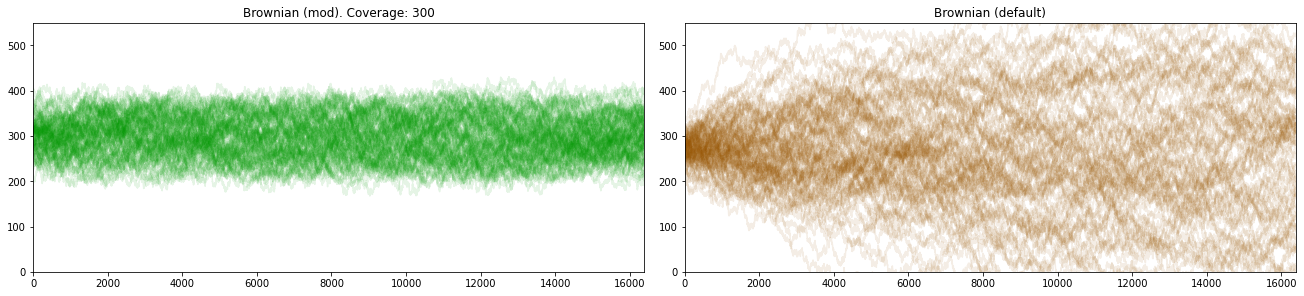

In [9]:
axs = plt.figure(figsize=(18, 4), constrained_layout=True).subplots(1, 2)
titles = ['Brownian (mod). Coverage: 300', 'Brownian (default)']
[axs[0].plot(one, alpha=0.1, color='#090') for one in brownian_mod[300]]
[axs[1].plot(one, alpha=0.1, color='#950') for one in brownian_default]
for i in [0, 1]:
    axs[i].set_xlim(0, 2**14)
    axs[i].set_ylim(0, 550)
    axs[i].set_title(titles[i])
plt.show()

### 3. Код Сергея. Отрицательное биномиальное распределение

Используется моделирование парных ридов отрицательным биномиальным распределением (`NB directly` `paired`) с заранее оценёнными параметрами. Портировано в python из R, исходник `Cover_NB.R`.

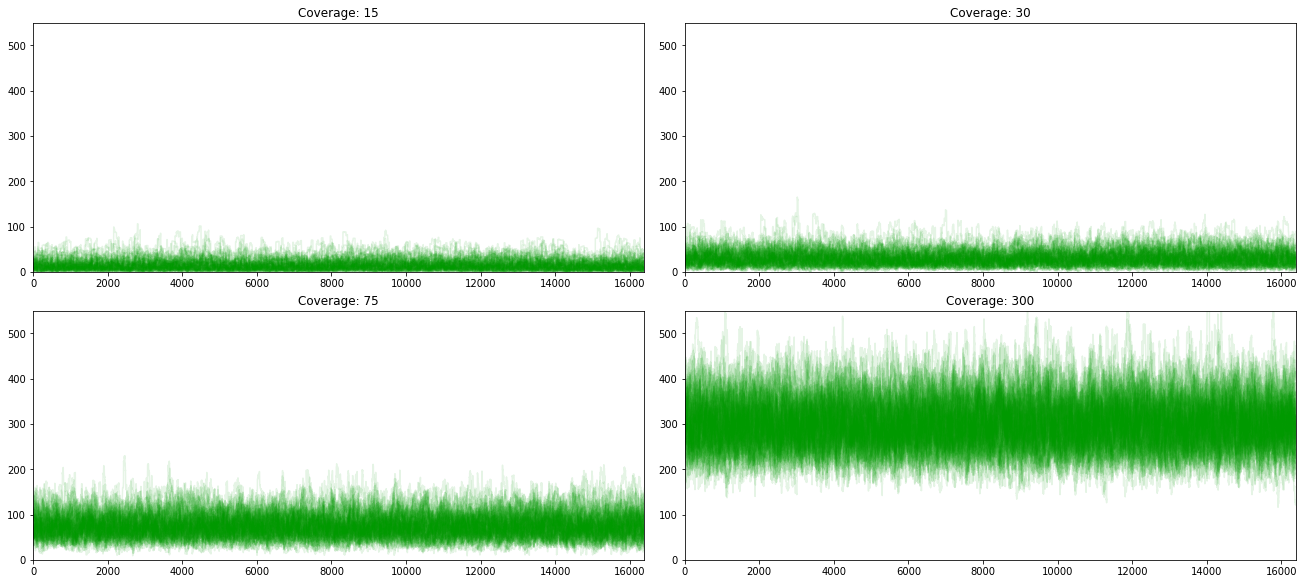

In [6]:
l_read, int_r = (150, 400)
prob = 0.1091639934 # nb_mle2_m
l_pair = 2 * l_read + int_r
l_rem  = l_pair - l_read + 1

def generate_NB(n, cov):
    size = cov * prob / (1 - prob) / l_read / 2
    samples = n - l_read + 1
    x = np.pad(np.random.negative_binomial(size, prob, samples), (l_read, l_read - 1))
    y = [(np.sum(x[k:(l_read+k)]) + np.sum(x[(l_rem+k):(l_pair+k)])) for k in range(n)]
    return list(map(int, y))

offset = 4000
cover_NB = {}
for cov, _ in coverage:
    cover_NB[cov] = []
    for i in range(80):
        one = generate_NB(2**14 + 2 * offset, cov)[offset:-offset]
        cover_NB[cov].append(one)
    with open(f'../../data/generated/cover_NB_{cov}.json', 'w') as f:
        json.dump(cover_NB[cov], f)    

axs = plt.figure(figsize=(18, 8), constrained_layout=True).subplots(2, 2)
for i, cov in enumerate(cover_NB):
    [axs.flat[i].plot(one, alpha=0.1, color='#090') for one in cover_NB[cov]]
    axs.flat[i].set_xlim(0, 2**14)
    axs.flat[i].set_ylim(0, 550)
    axs.flat[i].set_title(f"Coverage: {cov}")
plt.show()

## Внесение аберраций

Любая из аберраций вносится с плавным переходом через арктангенсы

In [11]:
def atans(center, size, T, L=2**14):
    left, right = (center - size/2, center + size/2)
    x = np.arange(0, L, 1)
    return np.array([1 - (np.arctan(i-left)/(np.pi) + 0.5) * (np.arctan(-(i-right))/(np.pi) + 0.5) * T for i in x])

def mNoise(src, noise, center, size):
    t = atans(center, size, 1)
    return t * src + (1 - t) * noise

def mDEL(src, center, size, k=0.8):
    noise = [max(0, int(v)) for v in (src - np.mean(src) * k)]
    return mNoise(src, noise, center, size)

def mDUP(src, center, size, k=-1):
    return atans(center, size, k) * src

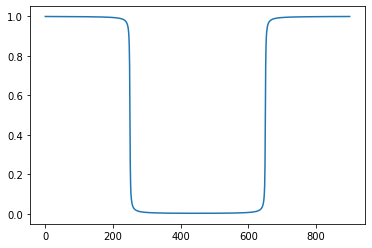

In [12]:
# Пример графика функции перехода:
plt.plot(atans(450, 400, 1, 900))
plt.ylim(-0.05,1.05)
plt.show()

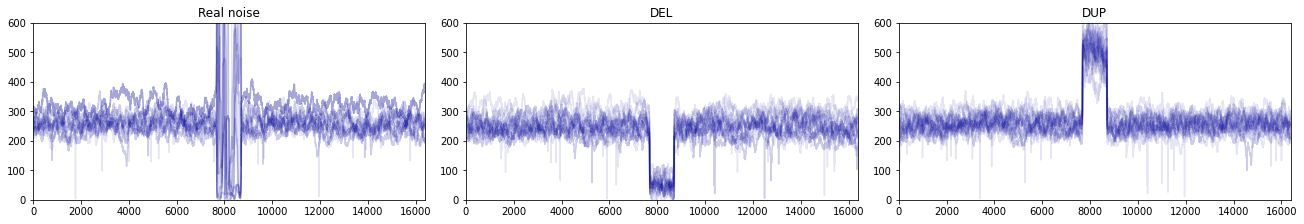

In [13]:
axs = plt.figure(figsize=(18, 3), constrained_layout=True).subplots(1, 3)

axs.flat[0].set_title(f"Real noise")
for i in np.random.choice(range(len(real_noise_sig)), 20):
    one = mNoise(real_good_sig[i], real_noise_sig[i], 2**13, 2**10)
    axs.flat[0].plot(one, alpha=0.1, color='#009')

axs.flat[1].set_title(f"DEL")
for i in np.random.choice(range(len(real_good_sig)), 20):
    one = mDEL(real_good_sig[i], 2**13, 2**10)
    axs.flat[1].plot(one, alpha=0.1, color='#009')

axs.flat[2].set_title(f"DUP")
for i in np.random.choice(range(len(real_good_sig)), 20):
    one = mDUP(real_good_sig[i], 2**13, 2**10)
    axs.flat[2].plot(one, alpha=0.1, color='#009')

for subplot in axs:
    subplot.set_xlim(0, 2**14)
    subplot.set_ylim(0, 600)
plt.show()

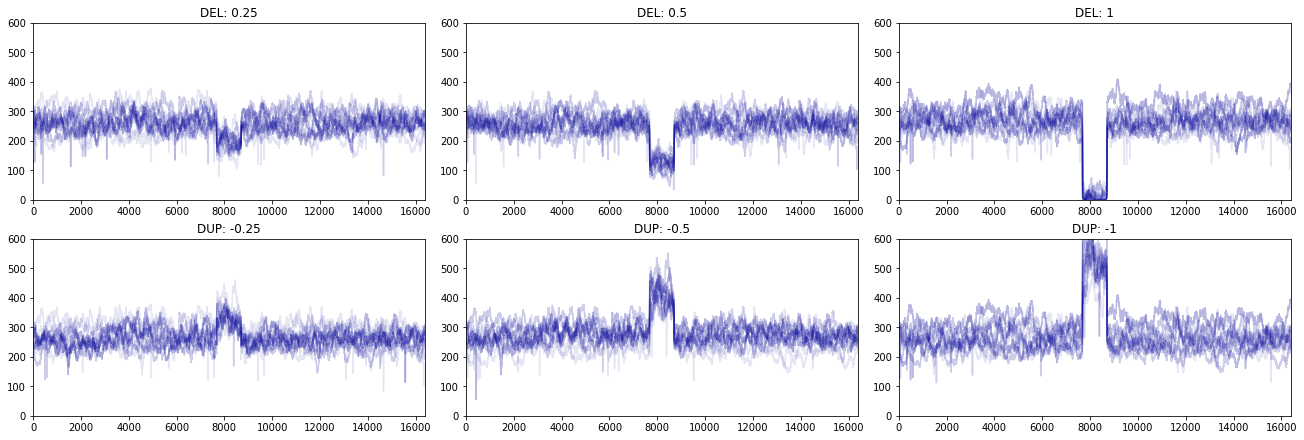

In [10]:
axs = plt.figure(figsize=(18, 6), constrained_layout=True).subplots(2, 3)
for g, k in enumerate([0.25, 0.5, 1]):
    axs[0][g].set_title(f"DEL: {k}")
    for i in np.random.choice(range(len(real_noise_sig)), 20):
        one = mDEL(real_good_sig[i], 2**13, 2**10, k)
        axs[0][g].plot(one, alpha=0.1, color='#009')

for g, k in enumerate([-0.25, -0.5, -1]):
    axs[1][g].set_title(f"DUP: {k}")
    for i in np.random.choice(range(len(real_noise_sig)), 20):
        one = mDUP(real_good_sig[i], 2**13, 2**10, k)
        axs[1][g].plot(one, alpha=0.1, color='#009')

for subplot in axs.flat:
    subplot.set_xlim(0, 2**14)
    subplot.set_ylim(0, 600)

plt.show()

Прототип:

In [13]:
sys.path.append('../tools')
from pylas import *

step  = 2**10
sizes = 2**np.arange(7, 15)
src, mean, aberr, scale = ('../../data/generated/cover_NB_75.json', 300, 'DEL', 1)

with open(src, 'r') as f:
    regions = json.load(f)

for i, s in enumerate(regions[1:3]):
    fft, dtt = (FFT_dF(s), (DTCWT_Entropy(s)))
    print(f"0\t0\t{fft}\t{dtt}")
    for size in sizes:
        for position in np.arange(0, 2**14, step):
            if aberr == "DEL":
                s_mod = mDEL(np.array(s)/mean, size, position, scale)
                fft, dtt = (FFT_dF(s_mod), (DTCWT_Entropy(s_mod)))
                print(f"{size}\t{position}\t{fft}\t{dtt}")
                break
        break

0	0	3576.5206733922323	8.842348031149179
128	0	3577.5175876542075	8.842821747380746
0	0	3911.480542137685	8.875131046948184
128	0	3912.3518049991508	8.875260763924912


Схема прогона:

```bash
rdir="../../data/generated"
python3 synthetic_aberration.py $rdir/real_good.json 272 Noise 0 &
for s in 0.5 1 2; do
  python3 synthetic_aberration.py $rdir/real_good.json 272 DEL $s &
done
for s in 1 2 3; do
  python3 synthetic_aberration.py $rdir/real_good.json 272 DUP -$s &
done

for cov in 15 30 75 300; do
  python3 synthetic_aberration.py $rdir/brownian_$cov.json $cov Noise 0 &
  for s in 0.5 1 2; do
    python3 synthetic_aberration.py $rdir/brownian_$cov.json $cov DEL $s &
  done
  for s in 1 2 3; do
    python3 synthetic_aberration.py $rdir/brownian_$cov.json $cov DUP -$s &
  done
done
```

```bash
rdir="../../data/generated"
python3 synthetic_aberration.py $rdir/real_good.json 272 DEL 1 &
python3 synthetic_aberration.py $rdir/real_good.json 272 DUP -2 &
for cov in 15 30 75 300; do
  python3 synthetic_aberration.py $rdir/brownian_$cov.json $cov DEL 1 &
  python3 synthetic_aberration.py $rdir/brownian_$cov.json $cov DUP -2 &
done
```

2**np.arange(7, 14)

In [24]:
np.arange(32, 512 + 32, 32)

array([ 32,  64,  96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416,
       448, 480, 512])

array([   4,    8,   16,   32,   64,  128,  256,  512, 1024, 2048, 4096,
       8192])

In [ ]:
[ 4, 8, 16, 32, 64, 96, 128, 256,  512, 1024, 2048, 4096, 8192]